In [1]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, LinearInterpolation, Kvaerno5
from jax import grad, jit, vmap
import jax.numpy as np
import pandas as pd
import numpy as onp

import matplotlib.pyplot as plt

In [2]:
def fomite_foi_sc(t, x, params):
    S, C, ε = x

    # p2p
    γ  = params["γ"]
    β  = params["β"]
    σ  = params["σ"]
    δ  = params["δ"]
    α  = params["δ"]
    Nw = params["Nw"]

    # fom
    θ = params["θ"]
    κ = params["κ"]

    λ1 = β * C / Nw
    λ2 = ε

    λ = λ1 + λ2

    sdot = (1-γ) * σ * Nw - λ * S - δ * S + α * C
    cdot = γ * σ * Nw     + λ * S - δ * C - α * C
    εdot = θ * C / Nw     - κ * ε

    return np.array([sdot, cdot, εdot])


In [5]:
params_sim_df = pd.DataFrame(columns=["γ", "β", "θ", "κ"])

gammas = [5/100, 25/100, 50/100, 75/100]
kappas = [1/(1 * 30),  1/(3*30), 1/(6*30), 1/(12*30), 1/(24*30), 1/(36*30)]
betas  = [0.01, 0.025, 0.05, 0.1]
tetas  = [1e-4, 1e-3, 1e-2]

idx_sim = 1
for g in gammas:
    for κ in kappas:
        for b in betas:
            for θ in tetas:
                    if b == betas[-1] and θ == tetas[-1]:
                         continue
                    params_sim_df = pd.concat([params_sim_df, pd.DataFrame.from_dict({"γ": g, "β": b, "θ": θ, "κ": κ, "sim_id": int(idx_sim)}, orient="index").T ], ignore_index=True)
                    idx_sim += 1


In [13]:
import diffrax

num_years = 4
t_max     = int((365) * num_years )      # simulate for 5 yrs but weekly
tsim      = np.arange(0, t_max+1) # list of days to simulate
num_sims  = len(params_sim_df.sim_id.unique())

t_save      = np.arange(0, t_max+1, 7) # list of days to simulate


solutions_arr = np.array([[],[],[],[],[],[],[],[]])
for idx_row, row in params_sim_df.iterrows():

        params = {
                "β":  row.β,
                "γ":  row.γ,
                "σ":  1/3 ,
                "δ":  1/3 ,
                "α":  1/120,
                "Nw": 2000,
                "θ" : row.θ,
                "κ" : row.κ
                }

        saveat = SaveAt(ts=t_save)
        model  = lambda t, x, args: fomite_foi_sc(t, x, params)
        term   = ODETerm(model)
        solver = Dopri5()

        stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

        c0 = int(row.γ * params["σ"] * params["Nw"])
        s0 = params["Nw"] - c0
        ε0 = 1e-4 # row.θ/row.κ *1/(params["α"] + params["δ"])
        y0 = np.array([s0,  c0, ε0])

        dt = 7
        try:
                solution = diffeqsolve(term, solver,
                                                t0=0, t1=t_max,
                                                saveat=saveat, dt0=dt, y0=y0,
                                                stepsize_controller = stepsize_controller)
        except:
                print(row, "failed")

        dummy_time = np.ones(round(t_max/dt))
        s, c, ε    = solution.ys.T
        y          = onp.concatenate([[solution.ts], [s], [c], [ε],
                                                [row.γ*dummy_time], [row.κ*dummy_time], [row.β*dummy_time], [row.θ*dummy_time] ], axis=0)
        solutions_arr = np.concatenate([solutions_arr, y], axis=1)

solution_df  = pd.DataFrame(columns=["time", "S", "C", "ε", "γ", "κ", "β", "θ"], data=solutions_arr.T)


γ          0.050000
β          0.010000
θ          0.010000
κ          0.001389
sim_id    47.000000
Name: 46, dtype: float64 failed
γ          0.050000
β          0.025000
θ          0.010000
κ          0.001389
sim_id    50.000000
Name: 49, dtype: float64 failed
γ          0.050000
β          0.050000
θ          0.010000
κ          0.001389
sim_id    53.000000
Name: 52, dtype: float64 failed
γ          0.050000
β          0.010000
θ          0.010000
κ          0.000926
sim_id    58.000000
Name: 57, dtype: float64 failed
γ          0.050000
β          0.025000
θ          0.010000
κ          0.000926
sim_id    61.000000
Name: 60, dtype: float64 failed
γ          0.050000
β          0.050000
θ          0.010000
κ          0.000926
sim_id    64.000000
Name: 63, dtype: float64 failed
γ           0.250000
β           0.010000
θ           0.010000
κ           0.001389
sim_id    113.000000
Name: 112, dtype: float64 failed
γ           0.250000
β           0.025000
θ           0.010000
κ      

In [14]:
import sys

sys.path.insert(0, "../")
from utils_local import plot_utils
import seaborn as sns


In [15]:
solution_df.to_csv("../results/solutions_model_1.1.csv", index=False)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/2013227394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_g_plt_df["s"]      = sol_g_plt_df["S"] / params["Nw"]
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/2013227394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_g_plt_df["c"]      = sol_g_plt_df["C"] / params["Nw"]


Text(0.5, 0.01, 'Time (days)')

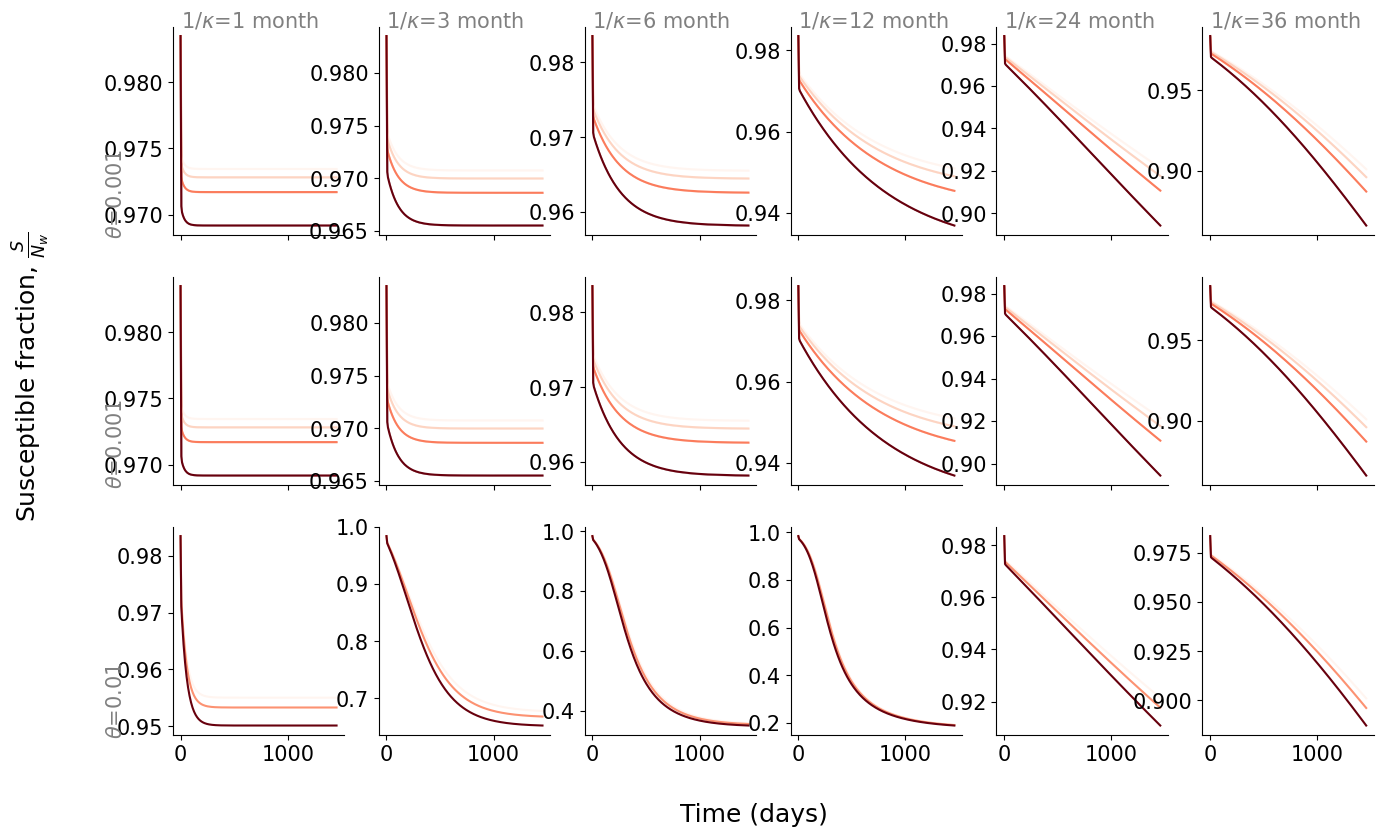

In [33]:
g                      = gammas[0]
sol_g_plt_df           = solution_df.query(f"γ == {g}")
sol_g_plt_df["s"]      = sol_g_plt_df["S"] / params["Nw"]
sol_g_plt_df["c"]      = sol_g_plt_df["C"] / params["Nw"]

fig, ax = plt.subplots(len(tetas), len(kappas), figsize=(15.5, 9.2), sharex=True, sharey=False)
for idx_k, k in enumerate(kappas):
    sol_k_plt_df  = sol_g_plt_df.query(f"γ == {g} and κ == {k}")
    for idx_teta, teta in enumerate(tetas):

        sns.lineplot(ax=ax[idx_teta, idx_k], x="time", y="s", data=sol_k_plt_df.query(f"θ=={teta}"), hue="β", palette="Reds")

        if idx_teta==0:
            ax[0, idx_k].text(x = 0,
                            y        = np.abs(ax[0, idx_k].get_ylim()[1]),
                            s        = r"$1/\kappa$={} month".format(int(1/k / 30)),
                            color    = "gray")

    for idx_teta, teta in enumerate(tetas):
        if idx_k ==0:
            ax[idx_teta, 0].text(x   = -700,
                            y        = ax[idx_teta, 0].get_ylim()[0],
                            s        = r"$\theta$={}".format(teta),
                            color    = "gray",
                            rotation = 90)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()
    axi.set_ylabel(None)
    axi.set_xlabel(None)

fig.supylabel(r"Susceptible fraction, $\frac{S}{N_w}$")
fig.supxlabel(r"Time (days)")


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/1417708943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_g_plt_df["s"]      = sol_g_plt_df["S"] / params["Nw"]
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/1417708943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_g_plt_df["c"]      = sol_g_plt_df["C"] / params["Nw"]
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/1417708943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

Text(0.5, 0.01, 'Time (days)')

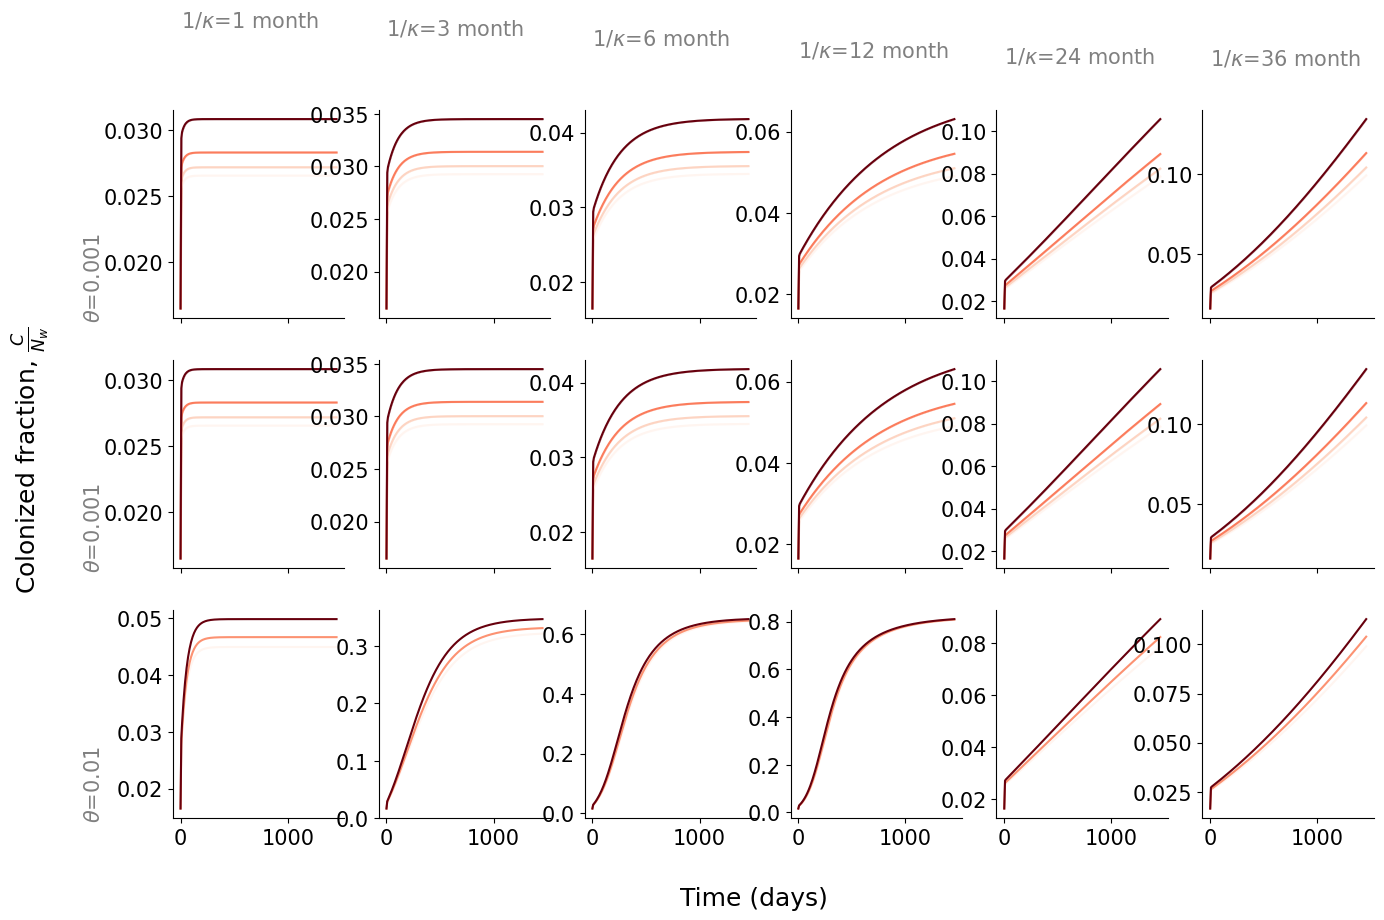

In [36]:
g                      = gammas[0]
sol_g_plt_df           = solution_df.query(f"γ == {g}")

sol_g_plt_df["s"]      = sol_g_plt_df["S"] / params["Nw"]
sol_g_plt_df["c"]      = sol_g_plt_df["C"] / params["Nw"]
sol_g_plt_df["ε_frac"] = sol_g_plt_df["ε"] / params["Nw"]

fig, ax = plt.subplots(len(tetas), len(kappas), figsize=(15.5, 9.2), sharex=True, sharey=False)
for idx_k, k in enumerate(kappas):
    sol_k_plt_df  = sol_g_plt_df.query(f"γ == {g} and κ == {k}")
    for idx_teta, teta in enumerate(tetas):

        sns.lineplot(ax=ax[idx_teta, idx_k], x="time", y="c", data=sol_k_plt_df.query(f"θ=={teta}"), hue="β", palette="Reds")

        if idx_teta==0:
            ax[0, idx_k].text(x = 0,
                            y        = np.abs(ax[0, idx_k].get_ylim()[1])*1.2,
                            s        = r"$1/\kappa$={} month".format(int(1/k / 30)),
                            color    = "gray")

    for idx_teta, teta in enumerate(tetas):
        if idx_k ==0:
            ax[idx_teta, 0].text(x   = -900,
                            y        = ax[idx_teta, 0].get_ylim()[0],
                            s        = r"$\theta$={}".format(teta),
                            color    = "gray",
                            rotation = 90)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()
    axi.set_ylabel(None)
    axi.set_xlabel(None)

fig.supylabel(r"Colonized fraction, $\frac{C}{N_w}$")
fig.supxlabel(r"Time (days)")


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/2828532726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_g_plt_df["s"]      = sol_g_plt_df["S"] / params["Nw"]
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_50263/2828532726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_g_plt_df["c"]      = sol_g_plt_df["C"] / params["Nw"]


Text(0.5, 0.01, 'Time (days)')

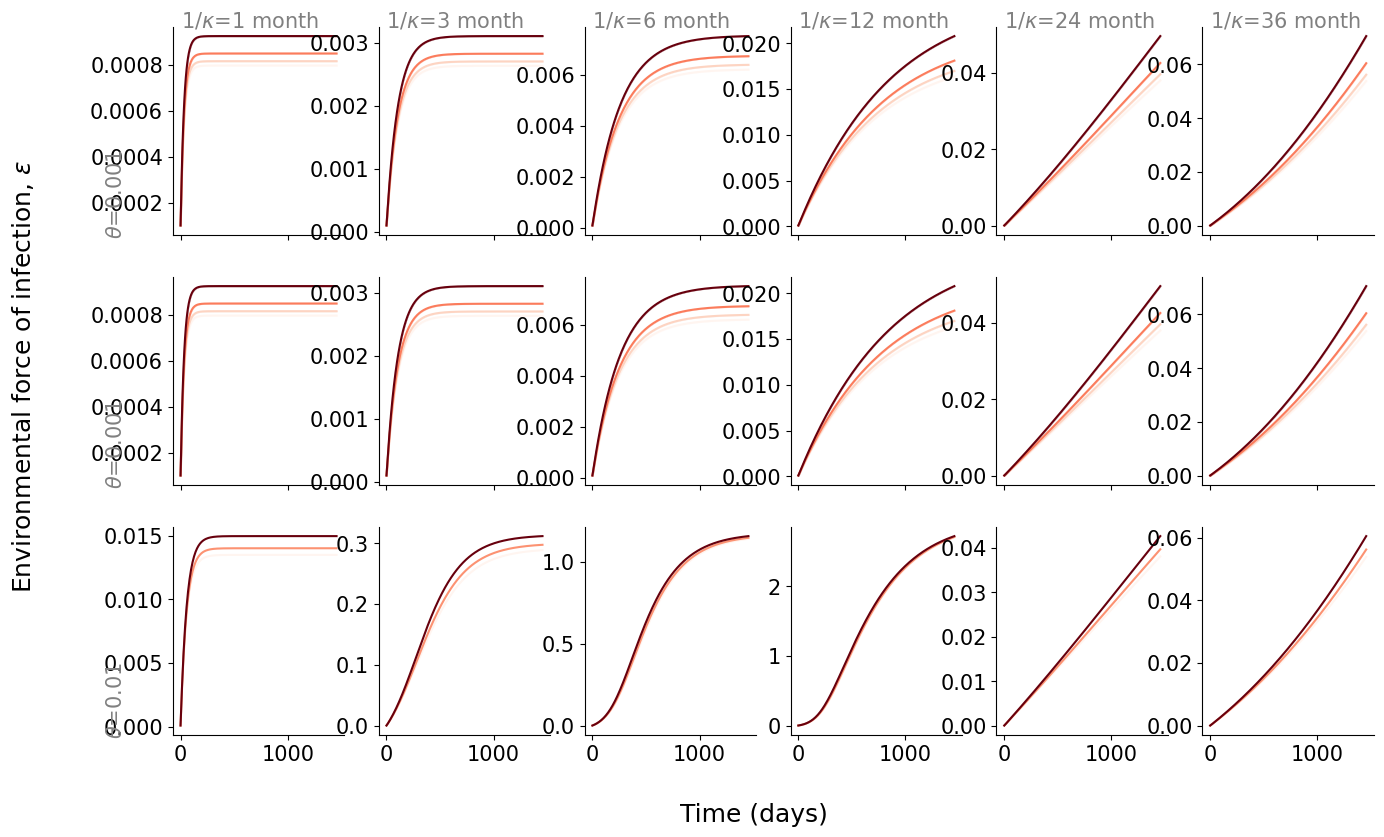

In [35]:
g                      = gammas[0]
sol_g_plt_df           = solution_df.query(f"γ == {g}")
sol_g_plt_df["s"]      = sol_g_plt_df["S"] / params["Nw"]
sol_g_plt_df["c"]      = sol_g_plt_df["C"] / params["Nw"]

fig, ax = plt.subplots(len(tetas), len(kappas), figsize=(15.5, 9.2), sharex=True, sharey=False)
for idx_k, k in enumerate(kappas):
    sol_k_plt_df  = sol_g_plt_df.query(f"γ == {g} and κ == {k}")
    for idx_teta, teta in enumerate(tetas):

        sns.lineplot(ax=ax[idx_teta, idx_k], x="time", y="ε", data=sol_k_plt_df.query(f"θ=={teta}"), hue="β", palette="Reds")

        if idx_teta==0:
            ax[0, idx_k].text(x = 0,
                            y        = np.abs(ax[0, idx_k].get_ylim()[1]),
                            s        = r"$1/\kappa$={} month".format(int(1/k / 30)),
                            color    = "gray")

    for idx_teta, teta in enumerate(tetas):
        if idx_k ==0:
            ax[idx_teta, 0].text(x   = -700,
                            y        = ax[idx_teta, 0].get_ylim()[0],
                            s        = r"$\theta$={}".format(teta),
                            color    = "gray",
                            rotation = 90)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()
    axi.set_ylabel(None)
    axi.set_xlabel(None)

fig.supylabel(r"Environmental force of infection, $\epsilon$")
fig.supxlabel(r"Time (days)")
